# Fast theta2 plot

In [11]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.offsetbox import AnchoredText

from lstchain.io.io import dl2_params_lstcam_key
from lstchain.reco.utils import (
    compute_theta2,
    extract_source_position,
    clip_alt,
    get_effective_time,
    radec_to_camera,
)
from ctapipe.containers import EventType
from ctapipe.coordinates import CameraFrame
from astropy.coordinates import (
    ICRS,
    Galactic,
    FK4,
    FK5,
    AltAz,
    SkyCoord,
    EarthLocation,
)
from astropy.time import Time
from gammapy.stats import WStatCountsStatistic

style.use('tableau-colorblind10')
plt.rcParams['font.size'] = 20

In [12]:
import lstchain
print("lstchain:", lstchain.__version__)

lstchain: 0.9.2


## This function gets the source position in camera coordinates for any source

In [13]:
def extract_source_position_from_coord(
    data, coord, equivalent_focal_length=28 * u.m
):
    """
    Extract source position from data
    Parameters:
    -----------
    pandas.DataFrame data: input data
    str observed_source_name: Name of the observed source
    astropy.units.m equivalent_focal_length: Equivalent focal length of a telescope
    Returns:
    --------
    2D array of coordinates of the source in form [(x),(y)] in astropy.units.m
    """

    obstime = pd.to_datetime(data["dragon_time"], unit="s")
    pointing_alt = u.Quantity(data["alt_tel"], u.rad, copy=False)
    pointing_az = u.Quantity(data["az_tel"], u.rad, copy=False)
    source_pos_camera = radec_to_camera(
        coord,
        obstime,
        pointing_alt,
        pointing_az,
        focal=equivalent_focal_length,
    )
    source_position = [source_pos_camera.x, source_pos_camera.y]
    return source_position

## Choose input files

In [127]:
%time
data=pd.DataFrame()
base_dir = '/fefs/aswg/workspace/alice.donini/Analysis/data/DL2/OT081/03_04/'
runs=['7247', '7248', '7249', '7250', '7268', '7269', '7270', '7271'] # You can concatenate several runs
for run in runs:
    input_file = base_dir + 'dl2_LST-1.Run0' + run + '.h5'
    data = pd.concat([data, pd.read_hdf(input_file, key=dl2_params_lstcam_key)])

CPU times: user 0 ns, sys: 17 µs, total: 17 µs
Wall time: 32.2 µs


In [128]:
# Take a look at the dataframe
data

obs_id  event_id    intensity  log_intensity         x         y  \
0          7247         1  5558.815268       3.744982 -0.004939  0.015149   
1          7247         2   141.059285       2.149402  0.163317  0.811628   
2          7247         4   142.004474       2.152302 -0.071148 -0.984977   
3          7247         5    82.812871       1.918098  0.706447 -0.135670   
4          7247         6   387.911234       2.588732 -0.353784 -0.610470   
...         ...       ...          ...            ...       ...       ...   
4703232    7271   6875377    26.366716       1.421056  0.363717  0.163353   
4703233    7271   6875380   316.378483       2.500207 -0.627153  0.324259   
4703234    7271   6875382    34.390079       1.536433 -0.543439  0.177228   
4703235    7271   6875383   609.365335       2.784878 -0.835687  0.627784   
4703236    7271   6875385    35.637082       1.551902  0.255900  0.675475   

                r       phi    length  length_uncertainty  ...  reco_disp_dx  \
0        0.015934  1.885987  1.129726            0.007532  ...      0.832716   
1        0.827897  1.372226  0.081826            0.004962  ...      0.050537   
2        0.987544 -1.642904  0.104376            0.006505  ...     -0.185304   
3        0.719357 -0.189736  0.089534            0.007189  ...      0.027651   
4        0.705576 -2.096026  0.200827            0.005634  ...     -0.343944   
...           ...       ...       ...                 ...  ...           ...   
4703232  0.398716  0.422124  0.072286            0.004999  ...      0.323878   
4703233  0.706020  2.664412  0.549196            0.007050  ...     -0.331546   
4703234  0.571608  2.826344  0.044486            0.001474  ...     -0.426950   
4703235  1.045221  2.497312  0.188546            0.004151  ...      0.121237   
4703236  0.722323  1.208659  0.066841            0.004855  ...     -0.279754   

         reco_disp_dy  reco_src_x  reco_src_y  signed_time_gradient  \
0           -0.015970    0.827777   -0.000821              0.812561   
1           -0.248039    0.213855    0.563589             -2.572229   
2            0.207286   -0.256451   -0.777691             -2.829985   
3           -0.377567    0.734098   -0.513237             -9.201743   
4            0.008421   -0.697729   -0.602050              1.243090   
...               ...         ...         ...                   ...   
4703232      0.058110    0.687595    0.221463              0.133079   
4703233      0.239815   -0.958699    0.564074              0.918155   
4703234      0.026139   -0.970389    0.203367             20.490553   
4703235      0.337459   -0.714450    0.965243              1.780293   
4703236      0.349490   -0.023854    1.024965            -11.338355   

         signed_skewness  reco_alt   reco_az  reco_type  gammaness  
0              -0.076595  0.834200  1.868510        101   0.003333  
1               0.845133  0.812062  1.897811        101   0.085833  
2               1.035164  0.795081  1.828885        101   0.115690  
3              -0.596836  0.830675  1.841381        101   0.297679  
4               0.158467  0.779484  1.838331        101   0.318167  
...                  ...       ...       ...        ...        ...  
4703232        -0.062316  1.015517  2.111565        101   0.234262  
4703233        -0.259290  0.956476  2.131501        101   0.000000  
4703234         0.075689  0.956315  2.109157        101   0.453071  
4703235         0.264297  0.964621  2.157079        101   0.420667  
4703236        -0.089569  0.989137  2.163228        101   0.329143  

[32056543 rows x 58 columns]

In [129]:
data.keys()

Index(['obs_id', 'event_id', 'intensity', 'log_intensity', 'x', 'y', 'r',
       'phi', 'length', 'length_uncertainty', 'width', 'width_uncertainty',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'alt_tel', 'az_tel', 'calibration_id', 'dragon_time',
       'ucts_time', 'tib_time', 'ucts_jump', 'mc_type', 'wl', 'tel_id',
       'tel_pos_x', 'tel_pos_y', 'tel_pos_z', 'trigger_type',
       'ucts_trigger_type', 'trigger_time', 'event_type', 'delta_t',
       'log_reco_energy', 'reco_energy', 'reco_disp_norm', 'reco_disp_sign',
       'reco_disp_dx', 'reco_disp_dy', 'reco_src_x', 'reco_src_y',
       'signed_time_gradient', 'signed_skewness', 'reco_alt', 'reco_az',
       'reco_type', 'gammaness'],
      dtype='object')

## Get the observation time and store some useful variables

In [130]:
obstime_real = get_effective_time(data)[0]
gammaness = np.array(data.gammaness)
leakage_intensity_width_2 = np.array(data.leakage_intensity_width_2)
intensity = np.array(data.intensity)
alt = np.array(data.alt_tel)
wl = np.array(data.wl)
event_type = np.array(data.event_type)
event_id = np.array(data.event_id)
obstime_real.to(u.min)

<Quantity 113.39652908 min>

## Define some cuts

In [131]:
gammaness_cut=0.7
intensity_cut=50

intensity_cut_high=1e10
alt_min=0 * np.pi / 180
wl_cut=0.0
THETA2_GLOBAL_CUT=0.04
theta2_range=(0,1)
norm_range_theta2_min=0.5
norm_range_theta2_max=1

In [132]:
condition = (gammaness > gammaness_cut) \
                                     & (intensity > intensity_cut) \
                                     & (intensity < intensity_cut_high) \
                                     & (alt > alt_min) \
                                     & (wl > wl_cut) \
                                     & (event_type != EventType.FLATFIELD.value)\
                                     & (event_type != EventType.SKY_PEDESTAL.value)\
                                     & (leakage_intensity_width_2 < 0.2)

In [133]:
# Apply now the cuts to the data
selected_data=data[condition]

## Define source coordinates

In [134]:
source_name = 'OT081'
#coords = ["17 51 12.0 +11 25 11.1"] #IC
coords = ["17 51 32.82 +9 39 00.73"]
coordinates = SkyCoord(coords, frame=ICRS, unit=(u.hourangle, u.deg))

filename_output = f'{source_name}'

## Calculate the source true position

In [135]:
%%time
true_source_position = extract_source_position_from_coord(selected_data, coordinates)
#true_source_position = extract_source_position(selected_data, 'Crab') #If its a catalogued source, like the Crab, you can use this lstchain function
off_source_position = [element * -1 for element in true_source_position]

CPU times: user 2min 47s, sys: 2.11 s, total: 2min 49s
Wall time: 2min 49s


## Compute theta2 of the ON and OFF data

In [136]:
theta2_on = np.array(compute_theta2(selected_data, true_source_position))
theta2_off = np.array(compute_theta2(selected_data, off_source_position))

## Create histograms for theta2 plots

In [137]:
#nbins=100 #Choose your preferred number of bins
nbins=round((theta2_range[1]/THETA2_GLOBAL_CUT)*2) # Make the histogram so there are only two bins before the theta2 cut
hist_on, bin_edges_on=np.histogram(theta2_on,density=False, bins=nbins, range=theta2_range)
hist_off, bin_edges_off=np.histogram(theta2_off, density=False, bins=nbins, range=theta2_range)

bin_width=bin_edges_on[1]-bin_edges_off[0]
bin_center=bin_edges_on[:-1]+(bin_width/2)



## Calculate the Li&Ma significance

In [138]:
N_on = np.sum(hist_on[bin_edges_on[1:]<=THETA2_GLOBAL_CUT])
N_off = np.sum(hist_off[bin_edges_off[1:]<=THETA2_GLOBAL_CUT])

N_off_err = np.sqrt(N_off)

idx_min = (np.abs(bin_edges_on - norm_range_theta2_min)).argmin()
idx_max = (np.abs(bin_edges_on - norm_range_theta2_max)).argmin()

Non_norm = np.sum(hist_on[idx_min:idx_max])
Noff_norm = np.sum(hist_off[idx_min:idx_max])

alpha = Noff_norm / Non_norm

stat = WStatCountsStatistic(n_on=N_on, n_off=N_off, alpha=alpha)
significance_lima = stat.sqrt_ts

textstr = r'N$_{{\rm on}}$ = {:.0f} '\
            f'\n'\
            r'N$_{{\rm off}}$ = {:.0f} $\pm$ {:.1f}'\
            f'\n'\
            r'Time = {:.1f}'\
            f'\n'\
            r'1/$\alpha$ = {:.1f}'\
            f'\n'\
            r'LiMa Significance = {:.1f} $\sigma$ '.format(N_on,
                                                      N_off,
                                                      N_off_err,
                                                      obstime_real.to(u.h),
                                                      1/alpha,
                                                      significance_lima)

print(alpha)
print(1/alpha)
#props = dict(boxstyle='Round', facecolor='white', alpha=0.5)

0.9995566252850266
1.000443571383309


## Plot Theta2

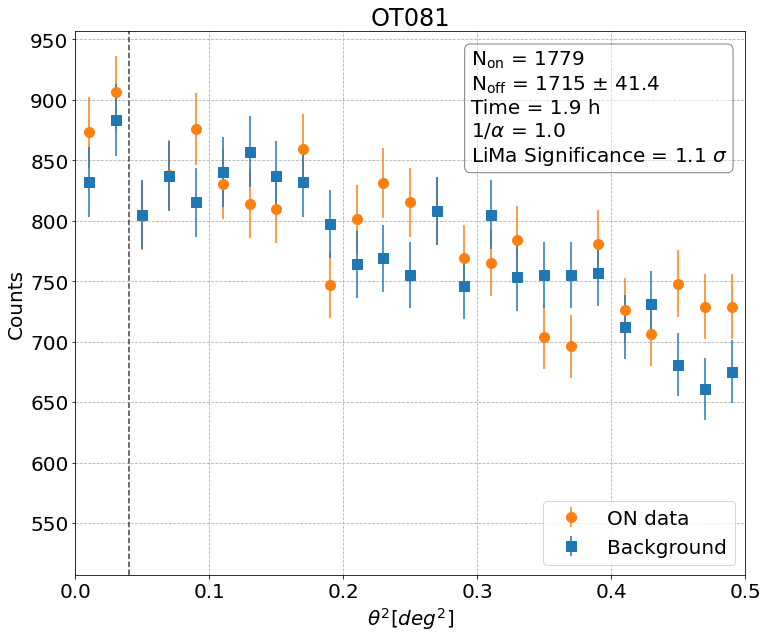

In [139]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.errorbar(bin_center, hist_on, yerr=np.sqrt(hist_on), fmt='o', label='ON data', ms=10, color='tab:orange')
ax.errorbar(bin_center, hist_off, yerr=np.sqrt(hist_off),fmt='s',label='Background', ms=10, color='tab:blue')
ax.set_xlim(0, 0.5)
#ax.set_xlim(left=0)
ax.grid(ls='dashed')
ax.axvline(THETA2_GLOBAL_CUT, color='black',ls='--',alpha=0.75)
ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
ax.set_ylabel("Counts")
ax.legend(loc='lower right')
ax.set_title(source_name)

box_prop = dict(boxstyle='Round', facecolor='white', alpha=0.5)
text_prop = dict(fontsize=20, bbox=box_prop)
txt = AnchoredText(textstr, loc=1, transform=ax.transAxes, prop=text_prop, frameon=False)
ax.add_artist(txt)
#txt = ax.text(0.57, 0.98, textstr, transform=ax.transAxes, fontsize='x-large',
#        verticalalignment='top', bbox=props)

plt.savefig(os.path.join(base_dir, f'{filename_output}_fast_theta2.png'), dpi=300)

## Plot excess counts

In [140]:
excess=hist_on-hist_off
excess_err=np.sqrt(np.sqrt(excess**2))

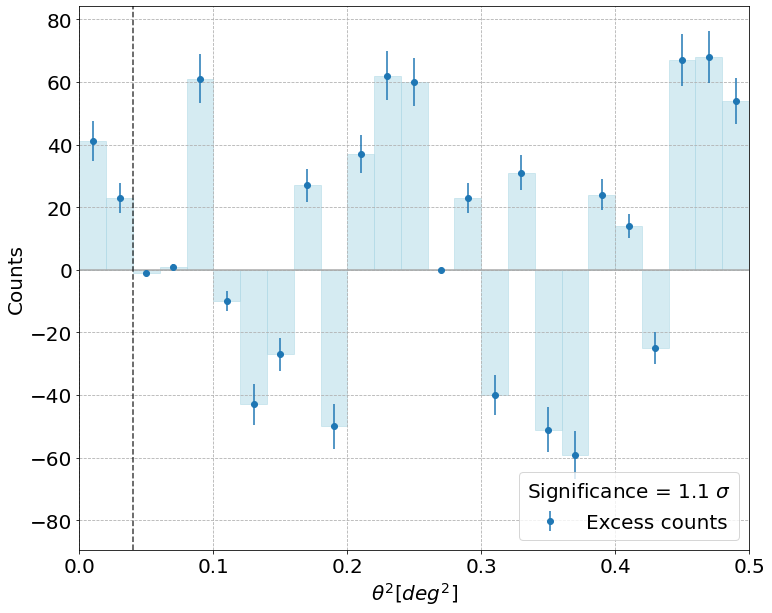

In [141]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.errorbar(bin_center, excess, yerr=excess_err,fmt='o',color='tab:blue',label='Excess counts')
ax.bar(bin_edges_on[:-1], excess, width = bin_width, align='edge', color='lightblue', ec='lightblue', alpha=0.5)
ax.axhline(0, color='darkgray')
ax.set_xlim(0, 0.5)
#ax.set_xlim(left=0)
ax.grid()
ax.axvline(THETA2_GLOBAL_CUT, color='black', ls='--', alpha=0.75)
ax.grid(ls='dashed')
ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
ax.set_ylabel("Counts")
ax.legend(title=f'Significance = {significance_lima:.1f} $\sigma$')

plt.savefig(os.path.join(base_dir, f'{filename_output}_fast_excess.png'), dpi=300)

## Theta2 plots for different bins in energy

### Define the energy binning

In [142]:
log_reco_energy = np.array(selected_data.log_reco_energy)
emin=0.01 * u.TeV
emax=10 * u.TeV
n_bins_energy=3
log_energy = np.linspace(np.log10(emin.to_value()),
                         np.log10(emax.to_value()),
                         n_bins_energy + 1)

### Calculate the significante and produce a theta2 plot for each energy bin

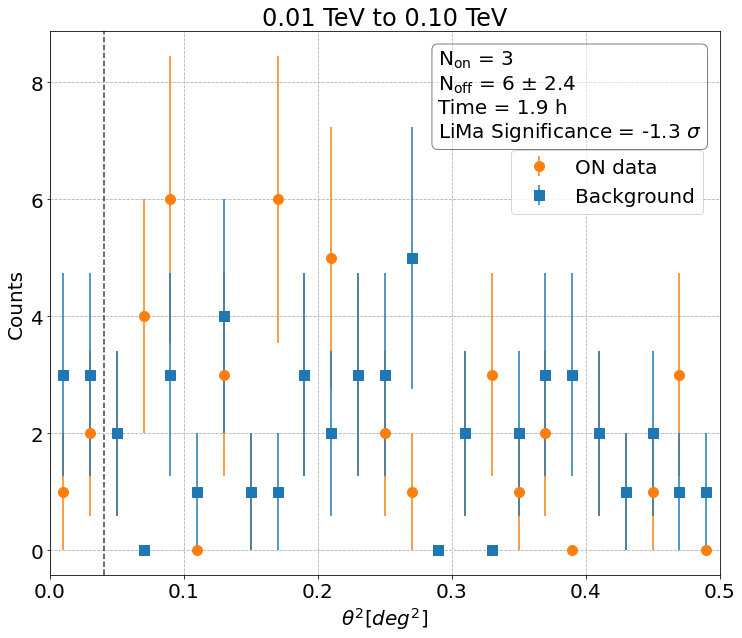

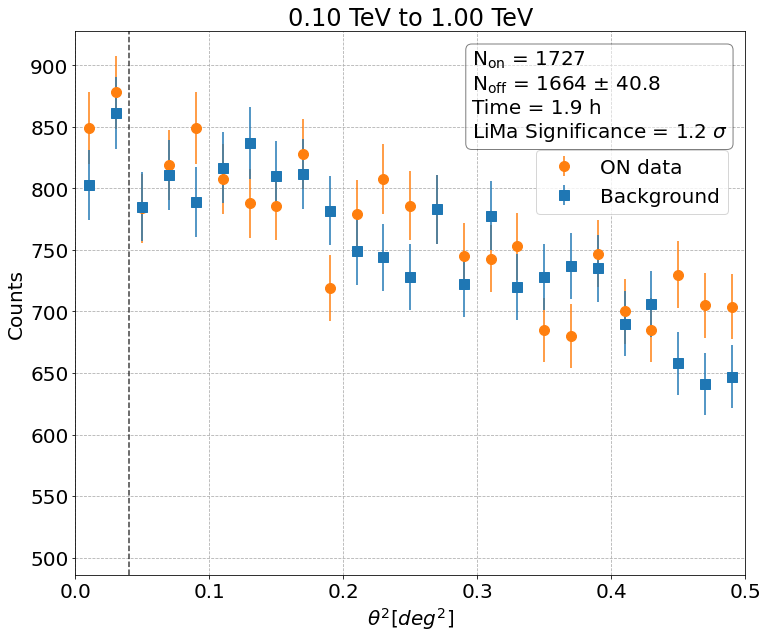

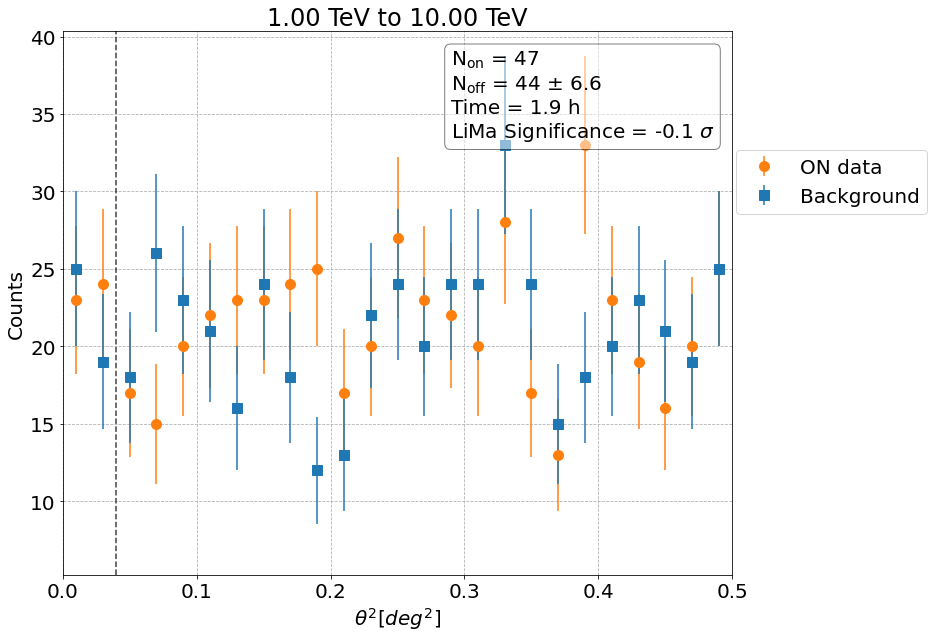

In [143]:
for i in range(n_bins_energy):
    condition_energy_bin= (log_reco_energy < log_energy[i+1]) \
        & (log_reco_energy >= log_energy[i])
    data_bin=selected_data[condition_energy_bin]
    theta2_on = np.array(compute_theta2(data_bin, (true_source_position[0][condition_energy_bin], true_source_position[1][condition_energy_bin])))
    theta2_off = np.array(compute_theta2(data_bin, (off_source_position[0][condition_energy_bin], off_source_position[1][condition_energy_bin])))
    
    hist_on, bin_edges_on=np.histogram(theta2_on,density=False, bins=nbins, range=theta2_range)
    hist_off, bin_edges_off=np.histogram(theta2_off, density=False, bins=nbins, range=theta2_range)

    bin_width=bin_edges_on[1]-bin_edges_off[0]
    bin_center=bin_edges_on[:-1]+(bin_width/2)
    N_on = np.sum(hist_on[bin_edges_on[1:]<=THETA2_GLOBAL_CUT])
    N_off = np.sum(hist_off[bin_edges_off[1:]<=THETA2_GLOBAL_CUT])
    
    N_off_err = np.sqrt(N_off)

    idx_min = (np.abs(bin_edges_on - norm_range_theta2_min)).argmin()
    idx_max = (np.abs(bin_edges_on - norm_range_theta2_max)).argmin()

    Non_norm = np.sum(hist_on[idx_min:idx_max])
    Noff_norm = np.sum(hist_off[idx_min:idx_max])

    alpha = Noff_norm / Non_norm

    stat = WStatCountsStatistic(n_on=N_on, n_off=N_off, alpha=alpha)
    significance_lima = stat.sqrt_ts

    textstr = r'N$_{{\rm on}}$ = {:.0f} '\
            f'\n'\
            r'N$_{{\rm off}}$ = {:.0f} $\pm$ {:.1f}'\
            f'\n'\
            r'Time = {:.1f}'\
            f'\n'\
            r'LiMa Significance = {:.1f} $\sigma$ '.format(N_on,
                                                      N_off,
                                                      N_off_err,
                                                      obstime_real.to(u.h),
                                                      significance_lima)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
    
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.errorbar(bin_center, hist_on, yerr=np.sqrt(hist_on), fmt='o', label='ON data', ms=10, color='tab:orange')
    ax.errorbar(bin_center, hist_off, yerr=np.sqrt(hist_off),fmt='s',label='Background', ms=10, color='tab:blue')
    ax.set_xlim(0, 0.5)
    ax.grid(ls='dashed')
    ax.axvline(THETA2_GLOBAL_CUT, color='black',ls='--',alpha=0.75)
    ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
    ax.set_ylabel("Counts")
    ax.legend(bbox_to_anchor=(0.99, 0.8))
    ax.set_title(r'{:.2f} TeV to {:.2f} TeV'.format(10**log_energy[i], 10**log_energy[i+1]))

    box_prop = dict(boxstyle='Round', facecolor='white', alpha=0.5)
    text_prop = dict(fontsize=20, bbox=box_prop)
    txt = AnchoredText(textstr, loc=1, transform=ax.transAxes, prop=text_prop, frameon=False)
    ax.add_artist(txt)
    #txt = ax.text(0.57, 0.98, textstr, transform=ax.transAxes, fontsize=20,
        #verticalalignment='top', bbox=props)

## Count Map: plot the position of the selected events

### In camera coordinates

Text(0, 0.5, 'y (m)')

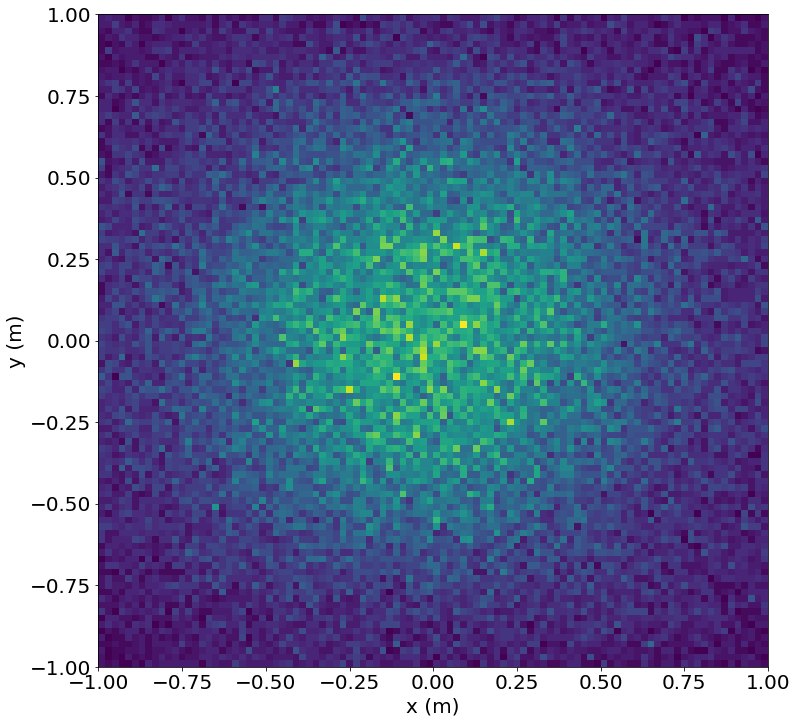

In [144]:
fig, ax = plt.subplots(figsize=(12, 12))

skymap=ax.hist2d(selected_data['reco_src_x'], 
           selected_data['reco_src_y'], bins=100, 
           range=[(-1,1), (-1,1)])
#plt.gca().scatter(sourcePos.ra, sourcePos.dec, transform=plt.gca().get_transform('world'), marker='+', c='k', label=source_name, s=[100])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

### In Sky coordinates

In [145]:
location = EarthLocation.from_geodetic(-17.89139 * u.deg, 28.76139 * u.deg, 2184 * u.m) #Location of LST1
obstime = pd.to_datetime(selected_data["dragon_time"], unit="s")
horizon_frame = AltAz(location=location, obstime=obstime)

In [146]:
%%time
pointing_alt = u.Quantity(selected_data["alt_tel"], u.rad, copy=False)
pointing_az = u.Quantity(selected_data["az_tel"], u.rad, copy=False)
pointing_direction=SkyCoord(alt=clip_alt(pointing_alt), az=pointing_az, frame=horizon_frame)
camera_frame = CameraFrame(focal_length=28 * u.m,
                           telescope_pointing=pointing_direction,
                           obstime=obstime,
                           location=location)  


CPU times: user 2min 11s, sys: 1.8 s, total: 2min 12s
Wall time: 2min 12s


In [147]:
camera_coords = SkyCoord(x=selected_data['reco_src_x'], y=selected_data['reco_src_y'], frame=camera_frame, unit=(u.m, u.m))

In [148]:
radec_coords=camera_coords.transform_to(frame=ICRS)

Text(0, 0.5, 'Declination (deg)')

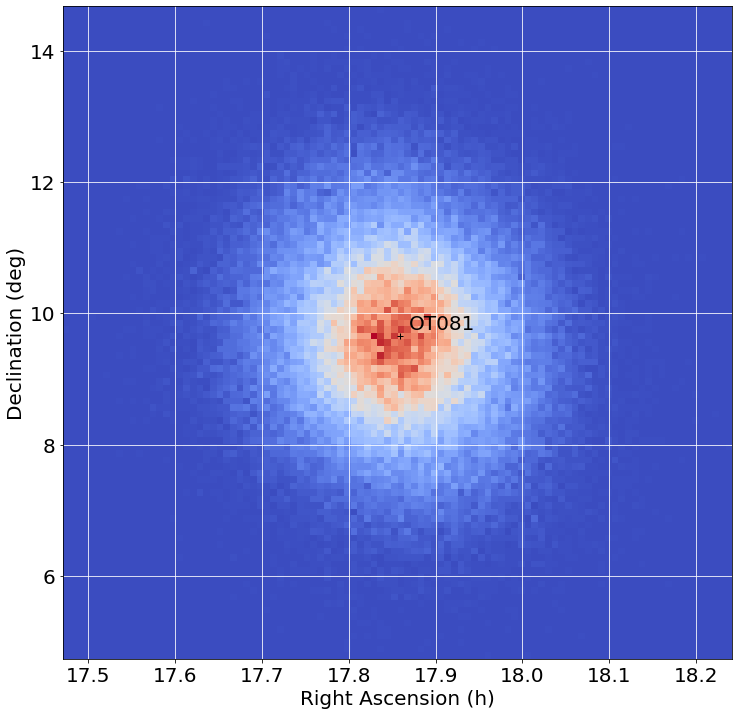

In [149]:
fig, ax = plt.subplots(figsize=(12, 12))
radec_skymap=plt.hist2d(radec_coords.ra.to_value(u.hourangle), 
           radec_coords.dec.value, 
           bins=100, cmap='coolwarm')
ax.plot(coordinates[0].ra.to_value(u.hourangle), coordinates[0].dec.value, marker='+', 
        color='k')
ax.text(coordinates[0].ra.to_value(u.hourangle)+0.01, coordinates[0].dec.value+0.1, source_name, c='k')
ax.grid(color='white')
ax.set_xlabel("Right Ascension (h)")
ax.set_ylabel("Declination (deg)")